# HFF Turbidity Analysis

## Business Understanding

Henry's Fork Foundation aims to preserve and restore the natural water quality of the Henry's Fork of the Snake River and its watershed. While their responsibilities are many, one of their chief aims is to use modern scientific techniques to keep tabs on the river and ensure local industrial and commercial practices are not interfering with its overall health and aesthetics. In turn, the river provides habitat for local flora and fauna, not to mention a large portion of the tourism revenue for the surrounding towns in the form of sport fishing.

To ensure optimal fishing experience the water conditions must be within acceptable ranges. Turbidity is the measure of clarity of a liquid, and in this case is very important to this experience. According to my correspondence with their Senior Scientist, Rob Van Kirk, "Turbidity is the single biggest factor affecting fishing experience. Anglers can't see things like dissolved oxygen or nutrient concentrations, but they can see how clear or dirty the water is. By far the single biggest complaint I get about fishing conditions is how turbid the water is."

I have been tasked with assessing and modeling data from multiple sources to determine major factors and predictors that contribute to turbidity in the river. Using this analysis and its framework, future scientists may be able to forecast water clarity and even mitigate contributing factors.

## Data Understanding

The first dataset comes from the publically available sonde data at [HFF.org](https://henrysforkdata.shinyapps.io/scientific_website/). This data is updated every 15 minutes using an in-water monitoring device called a sonde. These devices measure water temperature, turbidity, dissolved oxygen, conductivity, phytoplankton, and cyanobacteria content. While the other factors can contribute to the turbidity of a system on their own, they do not provide a complete picture.

We chose the sonde at this location because it is the head of one of the best regarded fishing areas, and its location just a few hundred yards downstream from Island Park Dam makes turbidity there less predictable and of higher concern. Determining the contributing factors to water clarity here could prove valuable in understanding how activity and management at Island Park reservoir impact the downstream water conditions.

The second dataset comes from the [US Bureau of Reclamation](https://www.usbr.gov/projects/index.php?id=151) and contains historical data regarding the water in island park reservoir, including in/outflow, elevation, and overall change in volume. While this data does not directly address the clarity of the water, the rate of flow in and out of the reservoir may kick up sediment and with the amount of exposed shoreline may affect the rate at which the shoreline erodes into the reservoir. This data dates back to 1929 which may be interesting to explore further once we have established the relevant tools for the job.

The third dataset comes from the [USDA Snotel Natural Resources Conservation Service
National Water and Climate Center](https://wcc.sc.egov.usda.gov/reportGenerator/view/customChartReport/daily/start_of_period/546:ID:SNTL%7Cid=%22%22%7Cname/CurrentWY,CurrentWYEnd/WTEQ::median_1981,WTEQ::median_1991,PREC::average_1981,PREC::median_1991?fitToScreen=false&useLogScale=false) which provides snow and climate monitoring at specific sites across the entire USA. The dataset we have is localized to our region, which we narrow further to sites that affect the watershed into the reservoir's tributaries. This has been collected since 1988 for this locale, which we again narrow into a timeframe we can use. The data includes the temperature at these sites, the daily and average precipitation, and the amount of water currently at the site in the form of snow.

## Data Preparation

First we import relevant libraries and format the data to be readable as a timeseries. Then, in order to get the data into a time scale that is relevant to the other datasets we downsample to daily frequency and split the data into training and testing sets. The data is in a timeseries, which precludes traditional random train/test splitting, and must be done using values that are in sequence. In this case, we take the most recent year with relatively complete data as the test set, and the rest of the complete years as the training data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import STL

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Import raw Island Park Dam sonde data
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert date to index and DateTime format
ipe_df = ipe_df.rename(columns={'contTime': 'date'})
ipe_df['date'] = pd.to_datetime(ipe_df.date)
data = ipe_df.drop(['date'], axis=1)
data.index = ipe_df.date

In [4]:
# Downsample data to daily frequency 
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1)

In [6]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [7]:
ipe_train = ipe_interp['2016':'2020']

In [8]:
ipe_test = ipe_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_20340\3605300567.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_test = ipe_interp['2021']


<AxesSubplot:xlabel='date'>

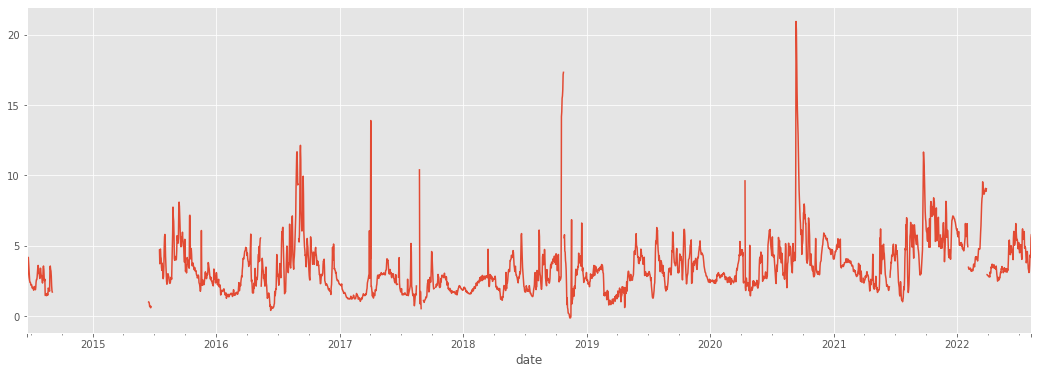

In [9]:
ipe_daily['Turb_FNU'].plot(figsize=(18,6))
plt.title

When we inspect the turbidity values here, we see there is a rather large gap early on in the time series, and a few smaller ones later on. These may bee too large for simple interpolation, especially with the high variance in data values over a short period of time. For this reason we will later drop these sections. Other NaN values will be interpolated over using the splining method to attempt to anticipate the patterns before modeling.

In [10]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [11]:
# drop redundant columns
hydro_df.drop(['volume.af', 'smoothed.vol', 'elevation.ft',
                   'smoothed.elev', 'surfacearea.acres'], axis=1, inplace=True)

In [12]:
hydro_df = hydro_df['2014':'2022']

In [13]:
# set the range of the data to the same as the sonde data
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [14]:
hydro_df_train = hydro_interp['2016':'2020']

In [15]:
hydro_df_test = hydro_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_20340\1673822024.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  hydro_df_test = hydro_interp['2021']


In [16]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP', 'WE.TMIN', 'WE.TMAX', 'CC.TMIN', 'CC.TMAX',
       'IP.TMIN', 'IP.TMAX'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE', 'CC.DP', 'CC.AP',
       'CC.SWE', 'IP.TAVE', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [17]:
climate_df = climate_df['2014':'2022']

In [18]:
clim_interp = climate_df.interpolate(method='spline', order=2)

In [19]:
climate_df_train = clim_interp['2016':'2020']

In [20]:
climate_df_test = clim_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_20340\3356747189.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  climate_df_test = clim_interp['2021']


Next, we combine the dataframes into their final training and testing sets, and inspect the resulting dataframe to ensure the structure looks correct, and there are no NaN values.

In [21]:
# Merge to create training set
final_train = pd.merge(climate_df_train, hydro_df_train, on=['date'])
final_train = pd.merge(final_train, ipe_train, on=['date'])

In [22]:
# Merge to create testing set
final_test = pd.merge(climate_df_test, hydro_df_test, on=['date'])
final_test = pd.merge(final_test, ipe_test, on=['date'])

In [23]:
# Inspect dataframe
final_test

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.0,0.0,8.2,7.3,19.0,0.0,4.0,3.6,23.0,0.0,...,286.371429,336.0,473.218701,450.186231,4.062128,0.367234,0.577872,6.902447,3.568787,136.174468
2021-01-02,19.0,0.2,8.4,7.6,20.0,0.3,4.3,3.9,24.0,0.3,...,311.414286,331.0,395.996470,437.342115,4.080745,0.375833,0.578333,6.966354,3.563354,135.673958
2021-01-03,22.0,0.4,8.8,7.9,24.0,0.1,4.4,4.0,27.0,0.3,...,305.214286,329.0,390.736122,441.850473,4.290000,0.358333,0.582187,6.949583,3.566958,135.616667
2021-01-04,25.0,0.7,9.5,8.6,26.0,0.4,4.8,4.5,30.0,0.3,...,296.328571,317.0,374.016665,446.983281,4.392083,0.338125,0.583333,6.870833,3.595531,135.275000
2021-01-05,23.0,0.6,10.1,9.0,25.0,0.2,5.0,4.7,29.0,0.4,...,288.200000,335.0,359.163160,441.158729,4.609674,0.344130,0.589783,7.111739,3.626120,135.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.0,0.5,17.3,12.9,13.0,0.4,11.5,6.5,17.0,0.6,...,345.381446,217.0,227.585681,315.894845,6.513646,0.608750,-0.044271,7.552292,3.786125,133.888542
2021-12-28,2.0,0.0,17.3,13.0,3.0,0.0,11.5,6.5,9.0,0.0,...,333.787929,226.0,392.313095,308.990468,6.322292,0.511563,-0.044167,7.495729,3.791698,133.850000
2021-12-29,6.0,0.3,17.6,13.3,8.0,0.1,11.6,6.6,11.0,0.3,...,304.581729,229.0,299.410937,320.837058,6.224894,0.510319,-0.062872,7.367872,3.828872,134.678723


In [24]:
# Check for NaNs
final_train.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [25]:
# Check for NaNs
final_test.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [26]:
# determine the lowest negative value so we can add that to all values to make the dataframe positive before scaling
final_train.min()

WE.TAVE                -5.000000
WE.DP                   0.000000
WE.AP                   0.000000
WE.SWE                  0.000000
CC.TAVE                -4.000000
CC.DP                   0.000000
CC.AP                   0.000000
CC.SWE                  0.000000
IP.TAVE                -8.000000
IP.DP                   0.000000
IP.AP                   0.000000
IP.SWE                  0.000000
net.evap.af         -1486.560444
delta.V.af          -2171.061429
regQ.cfs               71.900000
gain.cfs              -64.733023
smoothed.natQ.cfs     295.220945
Turb_FNU               -0.118526
Chloro_RFU             -0.332188
BGA_RFU                -0.453542
ODO_mgL                 3.373684
Temp_C                  2.639990
Cond_muSCm             71.887474
dtype: float64

In [27]:
# Logarithmic transformation after subtracting the most negative value 
final_train_log = np.log((final_train+2172))
final_test_log = np.log((final_test+2172))

C:\Users\harri\AppData\Local\Temp\ipykernel_20340\469378547.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(final_train['2020'])


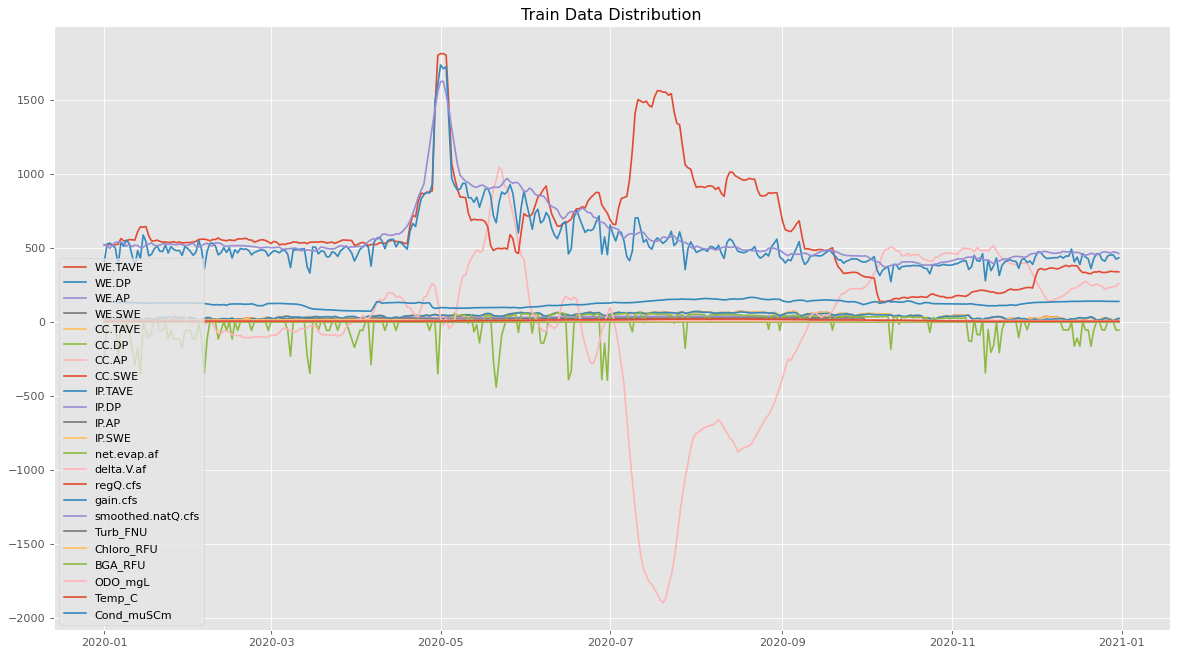

In [28]:
# Visualise train set for curiosity's sake
plt.figure(figsize=(18,10), dpi=80)
plt.plot(final_train['2020'])
plt.legend(final_train)
plt.title('Train Data Distribution');

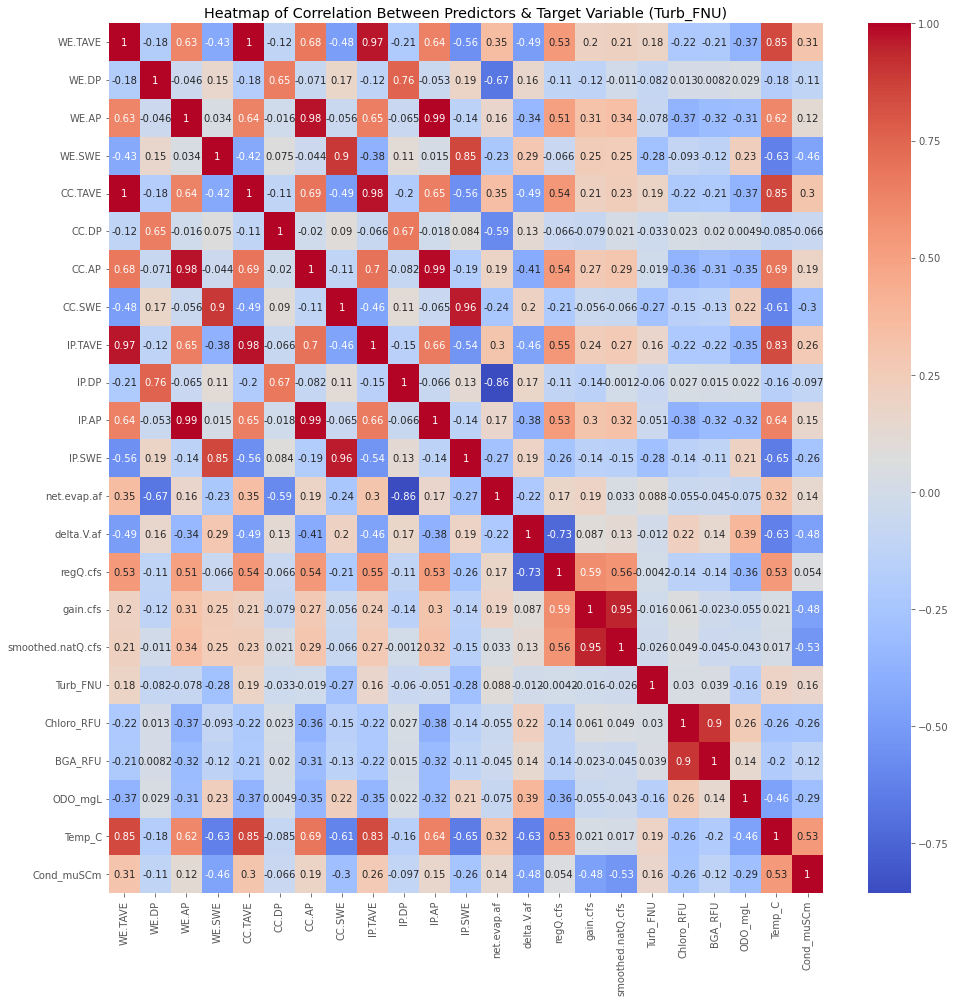

In [29]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))
# set up correlation matrix
corr = final_train.corr()
sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Turb_FNU)");
plt.show();

## OLS Model

First, we determine feature importance for a simple model to give an idea of the weights of the explanatory variables on turbidity. An OLS model allows us to use multivariate regression to capture the variance in the data.

In [30]:
# Instantiate and fit the OLS model, and provide output
ols = OLS(exog=final_train.drop(['Turb_FNU'], axis=1), endog=final_train['Turb_FNU'])
ols_model = ols.fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              299.4
Date:                Wed, 24 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:30:55   Log-Likelihood:                         -3565.4
No. Observations:                1827   AIC:                                      7175.
Df Residuals:                    1805   BIC:                                      7296.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [31]:
# Display standard deviations
final_train.std()

WE.TAVE               16.602699
WE.DP                  0.278735
WE.AP                 17.329576
WE.SWE                10.776551
CC.TAVE               16.611129
CC.DP                  0.193697
CC.AP                  9.495161
CC.SWE                 5.003882
IP.TAVE               16.159206
IP.DP                  0.169281
IP.AP                 10.288354
IP.SWE                 5.481206
net.evap.af          105.403773
delta.V.af           516.610946
regQ.cfs             336.144960
gain.cfs             219.347114
smoothed.natQ.cfs    235.757751
Turb_FNU               1.927556
Chloro_RFU             1.999588
BGA_RFU                0.641085
ODO_mgL                1.114011
Temp_C                 5.159372
Cond_muSCm            17.618043
dtype: float64

In [32]:
# Predict on the test set
ols_pred = ols_model.predict(final_test.drop(['Turb_FNU'], axis=1))

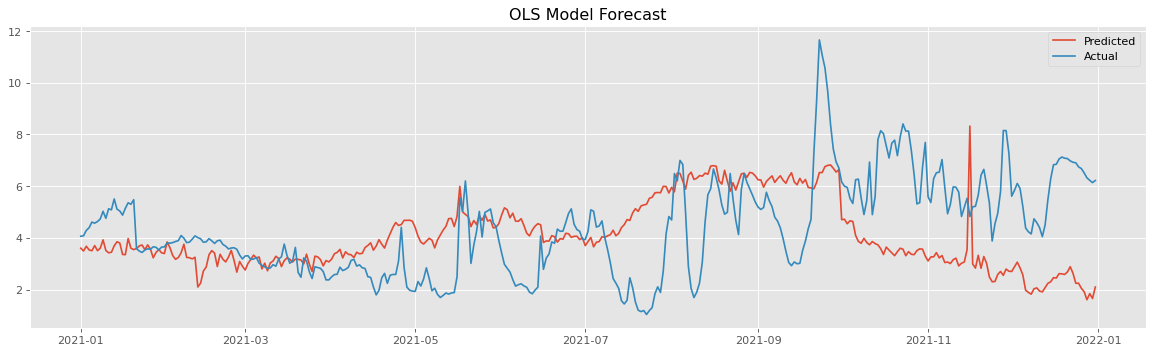

In [33]:
# Plot OLS model forecast
plt.figure(figsize=(18,5), dpi=80)
plt.plot(ols_pred, label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.title('OLS Model Forecast')
plt.legend();

In [34]:
# Calculate RMSE
dibrinse = ((final_test['Turb_FNU'])-ols_pred)
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

0.5311789017236513

This adjusted R2 value shows that the variance in the turbidity is about 79% captured by the explanatory variables according to this model. This does not necessarily mean our model can't get any better than this, but it may represent a loose ballpark for the upper bounds of how accurately we can predict the turbidity using basic methods. Additionally, multicollinearity is high here, which is to be expected. This can be mitigated by eliminating columns or using models that eliminate multicollinearity issues going forward.

The Durbin-Watson score here is low, implying the variance of the data is not constant throughout. This makes sense in this case, as even though the data is from the same time frame, it comes from three completely different sources. This is something to keep in mind and can be eliminated using a transformation. 

The coefficients here represent the amount of change in turbidity for a one unit change in the explanatory variable in question. Higher values can denote a larger influence in this simple model, but it is important to take into mind the scale of the variable and compare, which is why the standard deviation is included for context. If the coefficient is large but the scale of the variable is also large, that might not mean as significant an influence.

The p values here also should be taken in with a grain of salt, as a p value lower than 0.05 should mean we can reject the null hypothesis that the variable has no influence on the turbidity, and the converse is also true, that if the p value is higher than 0.05 we can reject the alternative hypothesis that the variable does have a significant influence. Using our background knowledge however, we know that high amounts of chlorophyll and BGA are linked to higher turbidity, which does not seem to be the case in this regression.

From this, we see that the factors that have a direct impact via low p values and high coefficients relative to their scale are all temperatures at the Snotel sites, which are collinear, as well as the amount of snow at the Island Park and Crab Creek sites. As snow melts at the Crab Creek site, the turbidity increases at Island Park, and then as the amount of snow increases at Island Park, the turbidity also increases, reflecting the effects of increased inflow into the reservoir from this inlet and possibly the effects of inclement weather respectively, as in the latter the average precipitation also has a low p value. The amount of dissolved oxygen also negatively correlates with the turbidity, showing that the conditions that increase turbidity also decrease the amount of biologically available oxygen. The conductivity positively correlates with the turbidity, which tracks, as the amount of dissolved salts and other inorganic compounds could hamper water clarity.

RMSE value averages the square of all the errors, and then takes the square root to get the number back into the scale of the data. The RMSE for the predictions vs actual here is surprisingly low, meaning given the information, this model is actually quite good.

The drawback of this model is that the data you provide it will often already contain the turbidity value, given the sonde. It can, however, be used to estimate the turbidity in cases where we have an idea going in of what the values for the predictors might be, as in the prediction for 2021. This means that this model cannot forecast very well without being given information about the future.

## VAR Model

The VAR model is a multivariate timeseries model that allows us to quickly compare the past and present verisions of a dataset to examine their relationship. This model does well for recurring patterns by creating vectors out of the predictor variables relationships, and then continuing the patterns for all variables.

In [35]:
#creating the train and validation set
train = final_train_log
valid = final_test_log

In [36]:
#make final predictions
model = VAR(endog=train.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
# Untransform and reformat the predictions
yhat_unt = pd.DataFrame((np.exp(yhat))-2172)
yhat_unt.set_index(final_test.index, inplace=True)
yhat_unt.columns = final_test.columns

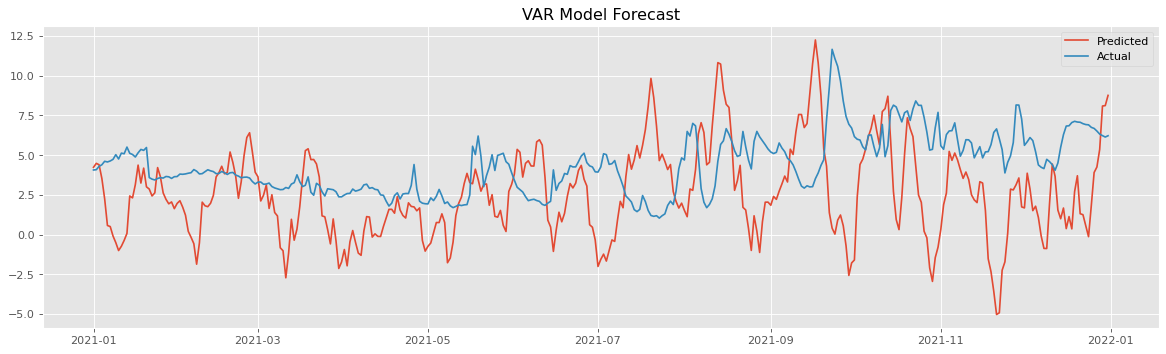

In [38]:
# Plot the predictions vs the actual values for 2021
plt.figure(figsize=(18,5), dpi=80)
plt.plot(yhat_unt['Turb_FNU'], label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.title('VAR Model Forecast')
plt.legend();

In [39]:
# Calculate RMSE
dibrinse = ((final_test['Turb_FNU']**2)-yhat_unt['Turb_FNU'])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

4.463655258001275

The above is the predicted values for turbidity using VAR. This result is if we were to predict the entire year without knowing any of the values for the predictor variables for the year. This shows that although the explanatory variables do contribute to the turbidity value, they themselves are not predictable due to major contributing factors not explained by the data.

The RMSE here is much worse, at 4.5, as the forecast has no information about the future values for which it is predicting, explanatory variables or otherwise. That said, the overall variance gets larger as the year goes on in both the predicted and actual values much like the years prior. The highs also seems to match the nearby peaks in the actual data as well. 

## LSTM Neural Network

Long Short Term Memory(LSTM) networks are a style of Recurrent Neural Network(RNN). RNNs are machine learning models that use the previous values to help predict the future values, and are the neural networks generally best suited to dealing with time series values. This works in theory, but these models tend toward stasis as they try to forecast further into the future. This essentially means that while the most recent values still affect the model, as the old ones get further from the current prediction, they begin to lose importance.

LSTM networks alleviate this problem by selectively forgetting information that it deems unimportant, while retaining the information it deems important. It determines the importance of the previous input using a sigmoid function to and then uses the same function along with the current input to create a vector telling the model how much of the new information to include in the new memory state. This new memory state is then retained and considered in with the next input, and so on.

In [40]:
# Make train and test sets
X_train = final_train.drop(['Turb_FNU'], axis=1)
y_train = final_train.Turb_FNU
X_test = final_test.drop(['Turb_FNU'], axis=1)
y_test = final_test.Turb_FNU

In [52]:
# Build the LSTM Neural Network

m = Sequential()
m.add(LSTM(units=50, return_sequences=True,
          input_shape=(X_train.shape[1],1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.1))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')


Epoch 1/3000
74/74 [==============================] - 3s 8ms/step - loss: 3.9806
Epoch 2/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.4828
Epoch 3/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3556
Epoch 4/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3234
Epoch 5/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.3227
Epoch 6/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2426
Epoch 7/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3032
Epoch 8/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2007
Epoch 9/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.1716
Epoch 10/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.1372
Epoch 11/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2417
Epoch 12/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.1671
Epoch 13/3000
74/74 [====

74/74 [==============================] - 1s 8ms/step - loss: 1.4388
Epoch 102/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.4930
Epoch 103/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.4045
Epoch 104/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.4387
Epoch 105/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3476
Epoch 106/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.4043
Epoch 107/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3628
Epoch 108/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3818
Epoch 109/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.7904
Epoch 110/3000
74/74 [==============================] - 1s 9ms/step - loss: 1.4210
Epoch 111/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.4357
Epoch 112/3000
74/74 [==============================] - 1s 9ms/step - loss: 1.3507
Epoch 113/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.8841
Epoch 200/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8991
Epoch 201/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8967
Epoch 202/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9356
Epoch 203/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.9193
Epoch 204/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.6229
Epoch 205/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.3401
Epoch 206/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.0325
Epoch 207/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.0034
Epoch 208/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9488
Epoch 209/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.0337
Epoch 210/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9200
Epoch 211/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 1.1596
Epoch 298/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.9515
Epoch 299/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8552
Epoch 300/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.9368
Epoch 301/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.8387
Epoch 302/3000
74/74 [==============================] - 1s 8ms/step - loss: 1.0087
Epoch 303/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.7700
Epoch 304/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.7011
Epoch 305/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.7288
Epoch 306/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6961
Epoch 307/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6914
Epoch 308/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6508
Epoch 309/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.5198
Epoch 396/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5320
Epoch 397/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5431
Epoch 398/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5911
Epoch 399/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5877
Epoch 400/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5217
Epoch 401/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5164
Epoch 402/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4741
Epoch 403/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.5483
Epoch 404/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.6195
Epoch 405/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5214
Epoch 406/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5019
Epoch 407/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.4190
Epoch 494/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4030
Epoch 495/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4129
Epoch 496/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3723
Epoch 497/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4514
Epoch 498/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3676
Epoch 499/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3850
Epoch 500/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3724
Epoch 501/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3540
Epoch 502/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3715
Epoch 503/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3736
Epoch 504/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4111
Epoch 505/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.3993
Epoch 592/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3472
Epoch 593/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3319
Epoch 594/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3362
Epoch 595/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3051
Epoch 596/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2886
Epoch 597/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3132
Epoch 598/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3238
Epoch 599/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3068
Epoch 600/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3231
Epoch 601/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3499
Epoch 602/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3102
Epoch 603/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.2715
Epoch 690/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2869
Epoch 691/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3043
Epoch 692/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2784
Epoch 693/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2659
Epoch 694/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3193
Epoch 695/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2837
Epoch 696/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2921
Epoch 697/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2703
Epoch 698/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3431
Epoch 699/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2870
Epoch 700/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2886
Epoch 701/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.4157
Epoch 788/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.8355
Epoch 789/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.7257
Epoch 790/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4648
Epoch 791/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3980
Epoch 792/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3620
Epoch 793/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3852
Epoch 794/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4105
Epoch 795/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3250
Epoch 796/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2745
Epoch 797/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2353
Epoch 798/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2270
Epoch 799/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.2115
Epoch 886/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2034
Epoch 887/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5710
Epoch 888/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.4967
Epoch 889/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3798
Epoch 890/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2865
Epoch 891/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2732
Epoch 892/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2987
Epoch 893/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2817
Epoch 894/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2574
Epoch 895/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2181
Epoch 896/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2494
Epoch 897/3000
74/7

74/74 [==============================] - 1s 8ms/step - loss: 0.2983
Epoch 984/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3019
Epoch 985/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2551
Epoch 986/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2688
Epoch 987/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3166
Epoch 988/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2722
Epoch 989/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2760
Epoch 990/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2547
Epoch 991/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2934
Epoch 992/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2777
Epoch 993/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2994
Epoch 994/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2682
Epoch 995/3000
74/7

74/74 [==============================] - 1s 9ms/step - loss: 0.2175
Epoch 1081/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2189
Epoch 1082/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1698
Epoch 1083/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2525
Epoch 1084/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3006
Epoch 1085/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2507
Epoch 1086/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1994
Epoch 1087/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1769
Epoch 1088/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1889
Epoch 1089/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1784
Epoch 1090/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1941
Epoch 1091/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2181
Epoch 10

74/74 [==============================] - 1s 9ms/step - loss: 0.1494
Epoch 1178/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1427
Epoch 1179/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1581
Epoch 1180/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1517
Epoch 1181/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1775
Epoch 1182/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1484
Epoch 1183/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1455
Epoch 1184/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1388
Epoch 1185/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1951
Epoch 1186/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1610
Epoch 1187/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1431
Epoch 1188/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1469
Epoch 11

74/74 [==============================] - 1s 9ms/step - loss: 0.1511
Epoch 1275/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1527
Epoch 1276/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1730
Epoch 1277/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1403
Epoch 1278/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1822
Epoch 1279/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2225
Epoch 1280/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3328
Epoch 1281/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2099
Epoch 1282/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1807
Epoch 1283/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2554
Epoch 1284/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3103
Epoch 1285/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1986
Epoch 12

74/74 [==============================] - 1s 9ms/step - loss: 0.1440
Epoch 1372/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1280
Epoch 1373/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1150
Epoch 1374/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2113
Epoch 1375/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.7809
Epoch 1376/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.4223
Epoch 1377/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3662
Epoch 1378/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3487
Epoch 1379/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2995
Epoch 1380/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.3140
Epoch 1381/3000
74/74 [==============================] - 1s 10ms/step - loss: 0.2139
Epoch 1382/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1769
Epoch 1

74/74 [==============================] - 1s 9ms/step - loss: 0.1155
Epoch 1469/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1092
Epoch 1470/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1223
Epoch 1471/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1284
Epoch 1472/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1118
Epoch 1473/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1239
Epoch 1474/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1194
Epoch 1475/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1579
Epoch 1476/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5145
Epoch 1477/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2687
Epoch 1478/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2297
Epoch 1479/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2013
Epoch 14

74/74 [==============================] - 1s 8ms/step - loss: 0.1049
Epoch 1566/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2317
Epoch 1567/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1415
Epoch 1568/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1158
Epoch 1569/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1235
Epoch 1570/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1122
Epoch 1571/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1210
Epoch 1572/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1046
Epoch 1573/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1278
Epoch 1574/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1030
Epoch 1575/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1261
Epoch 1576/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1272
Epoch 15

74/74 [==============================] - 1s 8ms/step - loss: 0.1238
Epoch 1663/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1150
Epoch 1664/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1112
Epoch 1665/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0997
Epoch 1666/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1124
Epoch 1667/3000
74/74 [==============================] - 1s 11ms/step - loss: 0.1120
Epoch 1668/3000
74/74 [==============================] - 1s 10ms/step - loss: 0.0972
Epoch 1669/3000
74/74 [==============================] - 1s 10ms/step - loss: 0.0958
Epoch 1670/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1073
Epoch 1671/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2182
Epoch 1672/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1365
Epoch 1673/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1271
Epoch

74/74 [==============================] - 1s 9ms/step - loss: 0.1040
Epoch 1760/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0972
Epoch 1761/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0915
Epoch 1762/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0919
Epoch 1763/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1073
Epoch 1764/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1018
Epoch 1765/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1144
Epoch 1766/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1048
Epoch 1767/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1337
Epoch 1768/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1128
Epoch 1769/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1425
Epoch 1770/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1041
Epoch 17

74/74 [==============================] - 1s 9ms/step - loss: 0.1520
Epoch 1857/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1540
Epoch 1858/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1473
Epoch 1859/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1550
Epoch 1860/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.2066
Epoch 1861/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1787
Epoch 1862/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1721
Epoch 1863/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2084
Epoch 1864/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1820
Epoch 1865/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1701
Epoch 1866/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1278
Epoch 1867/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1115
Epoch 18

74/74 [==============================] - 1s 8ms/step - loss: 0.1309
Epoch 1954/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0995
Epoch 1955/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0973
Epoch 1956/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0880
Epoch 1957/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0913
Epoch 1958/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0945
Epoch 1959/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0909
Epoch 1960/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0957
Epoch 1961/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1092
Epoch 1962/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0964
Epoch 1963/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0942
Epoch 1964/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0921
Epoch 19

74/74 [==============================] - 1s 9ms/step - loss: 0.0929
Epoch 2051/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1001
Epoch 2052/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0989
Epoch 2053/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0934
Epoch 2054/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0865
Epoch 2055/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0907
Epoch 2056/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0934
Epoch 2057/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0996
Epoch 2058/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0952
Epoch 2059/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1277
Epoch 2060/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1090
Epoch 2061/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0909
Epoch 20

74/74 [==============================] - 1s 8ms/step - loss: 0.2023
Epoch 2148/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1295
Epoch 2149/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1112
Epoch 2150/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1043
Epoch 2151/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1053
Epoch 2152/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0906
Epoch 2153/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0945
Epoch 2154/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1005
Epoch 2155/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0814
Epoch 2156/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0941
Epoch 2157/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0886
Epoch 2158/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1267
Epoch 21

74/74 [==============================] - 1s 9ms/step - loss: 0.0820
Epoch 2245/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0806
Epoch 2246/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0817
Epoch 2247/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0888
Epoch 2248/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0882
Epoch 2249/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0856
Epoch 2250/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0839
Epoch 2251/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0886
Epoch 2252/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0897
Epoch 2253/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0906
Epoch 2254/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0773
Epoch 2255/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0966
Epoch 22

74/74 [==============================] - 1s 8ms/step - loss: 0.0811
Epoch 2342/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0918
Epoch 2343/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2499
Epoch 2344/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2023
Epoch 2345/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1613
Epoch 2346/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1553
Epoch 2347/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1391
Epoch 2348/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0971
Epoch 2349/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1046
Epoch 2350/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0954
Epoch 2351/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0820
Epoch 2352/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0981
Epoch 23

74/74 [==============================] - 1s 9ms/step - loss: 0.0642
Epoch 2439/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0861
Epoch 2440/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0696
Epoch 2441/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0705
Epoch 2442/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0845
Epoch 2443/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1860
Epoch 2444/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2852
Epoch 2445/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.5056
Epoch 2446/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.2801
Epoch 2447/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.3039
Epoch 2448/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1929
Epoch 2449/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1555
Epoch 24

74/74 [==============================] - 1s 8ms/step - loss: 0.2554
Epoch 2536/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1782
Epoch 2537/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1420
Epoch 2538/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1403
Epoch 2539/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0987
Epoch 2540/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0997
Epoch 2541/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0790
Epoch 2542/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0943
Epoch 2543/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0883
Epoch 2544/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0735
Epoch 2545/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0830
Epoch 2546/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0758
Epoch 25

74/74 [==============================] - 1s 8ms/step - loss: 0.0620
Epoch 2633/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1036
Epoch 2634/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0890
Epoch 2635/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0890
Epoch 2636/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0912
Epoch 2637/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0873
Epoch 2638/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0805
Epoch 2639/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0851
Epoch 2640/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0817
Epoch 2641/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0731
Epoch 2642/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0682
Epoch 2643/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0654
Epoch 26

74/74 [==============================] - 1s 8ms/step - loss: 0.0712
Epoch 2730/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0631
Epoch 2731/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0705
Epoch 2732/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0685
Epoch 2733/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0770
Epoch 2734/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0686
Epoch 2735/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0707
Epoch 2736/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0654
Epoch 2737/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0679
Epoch 2738/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0777
Epoch 2739/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0744
Epoch 2740/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0674
Epoch 27

74/74 [==============================] - 1s 9ms/step - loss: 0.0817
Epoch 2827/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0869
Epoch 2828/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0773
Epoch 2829/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0936
Epoch 2830/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0749
Epoch 2831/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0861
Epoch 2832/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0869
Epoch 2833/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0765
Epoch 2834/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0767
Epoch 2835/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0732
Epoch 2836/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0713
Epoch 2837/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0780
Epoch 28

74/74 [==============================] - 1s 8ms/step - loss: 0.0780
Epoch 2924/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0777
Epoch 2925/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0706
Epoch 2926/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0766
Epoch 2927/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0742
Epoch 2928/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.0790
Epoch 2929/3000
74/74 [==============================] - 1s 9ms/step - loss: 0.1067
Epoch 2930/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0751
Epoch 2931/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0852
Epoch 2932/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0834
Epoch 2933/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.1034
Epoch 2934/3000
74/74 [==============================] - 1s 8ms/step - loss: 0.0822
Epoch 29

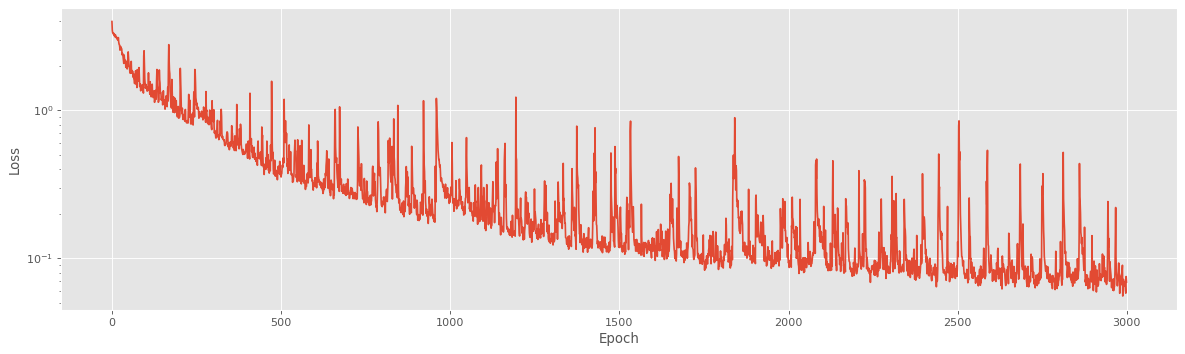

In [42]:
# Fit the model to the data
history = m.fit(X_train, y_train, epochs=3000, batch_size=25, verbose=1)

# Plot the loss of the model as each epoch passes
plt.figure(figsize=(18,5), dpi=80)
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [43]:
# Use the fitted LSTM to predict on the test set
y_pred = m.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.set_index(X_test.index, inplace=True)

12/12 [==============================] - 1s 3ms/step


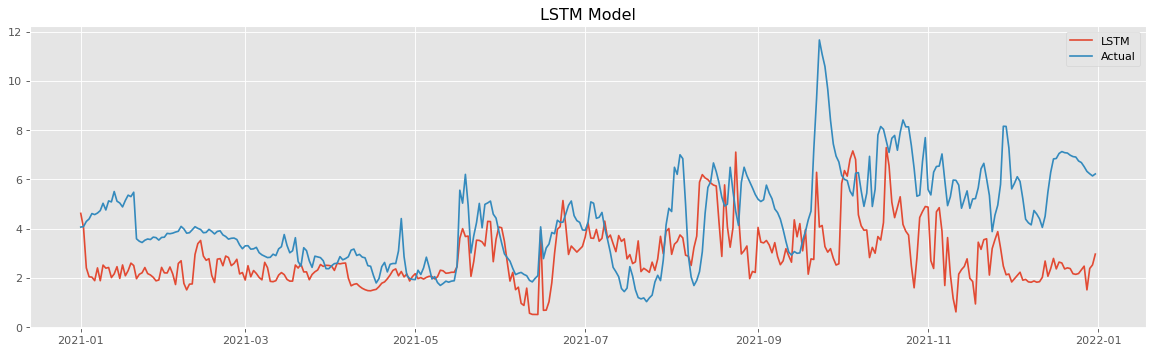

In [44]:
# Plot the LSTM results
plt.figure(figsize=(18,5), dpi=80)
plt.plot(y_pred,label='LSTM')
plt.plot(y_test,label='Actual')
plt.title('LSTM Model')
plt.legend();

In [45]:
# Calculate correlation between predictions and actual values
pd.DataFrame(y_test)['Turb_FNU'].corr(pd.DataFrame(y_pred)[0])

0.3936468425373227

In [46]:
# Calculate RMSE
dibrinse = (pd.DataFrame(y_test)['Turb_FNU']-pd.DataFrame(y_pred)[0])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

1.2263186350112207

The predicted and actual values for turbidity in 2021 are displayed in the graph above. Many of the peaks and valleys match up even though their magnitude may not always match. The RMSE here is relatively low, roughly a third of that of the VAR model, and shows that for any given point in time, the model is on average only off by 1.3.

While the RMSE for this model is not as high as that of the OLS model, this model stands to improve the most without considering new variables, given that the machine learning element of this model automatically picks up the signal, and that the loss is steadily decreasing, even after 3000 epochs.

## Conclusions

All three models have their merits, and picking one requires knowledge of their underlying principles and the desired result. The fastest way to get a low variance prediction that is closest to the mean of forecasted values is the OLS regression. This model also has the added advantage of describing the relationship of the predictor variables to the turbidity, which is one of the major goals of this project. The most important factors are precipitation and snowmelt at White Elephant, which feeds rivers upstream in the Mack's Inn area, precipitation and snowmelt at the Island Park Dam, dissolved oxygen, which decreases as turbidity goes up, conductivity, with a positive correlation with turbidity, and temperature at both Island Park Dam and White Elephant. The disadvantage of this model is that it needs estimates for the future values of these explanatory variables in order to work.

The VAR model is possibly the best to use when you have no future data and this is its strongest point. The predictions it generates approximate the typical year of turbidity, with some flaws. The variance at the start of the year is a little too much, and the peaks do not line up exactly when they should happen, although this latter problem is likely caused by meteorological events not included in our data.

The LSTM model is the most adaptible, and can forecast with or without the explanatory variables provided. In this way it acts as sort of a blend of the previous two models, and with a relatively low RMSE it still predicts spikes in turbidity fairly wel, as opposed to the VAR model. Where the VAR is set up to forecast given no extra information out of the box, the LSTM could in the future use the predictions of the VAR model to provide more accurate results. As far as monitoring the turbidity, the best way to do that is the LSTM model with forecsats for the other variables provided.